# Банки - анализ оттока клиентов

Необходимо проанализировать клиентов регионального банка и выделить сегменты, которые склонны уходить из банка.

**Материалы**:
 * [Презентация](https://disk.yandex.ru/i/na_hUUDDO3gDJQ)

**План работы:**
1. [Загрузка и изучение данных](#загрузка) 
2. [Подготовка данных:](#подготовка)
    * [Проверка на соответствие типам](#типы)
    * [Поиск дубликатов](#дубликаты)
    * [Проверка и анализ пропусков](#пропуски)
3. [Исследовательский анализ данных (EDA):](#анализ)
    * [Определение значимых признаков отточности](#отточность)
    * [Сравнение портретов типичных клиентов, которые склонны и не склонны уходить из банка](#портреты)
    * [Корреляционный анализ](#корреляция)
4. [Формулировка и проверка статистических гипотез:](#гипотезы)
    * [Первая гипотеза](#1)
    * [Вторая гипотеза](#2)
    * [Третья гипотеза](#3)
5. [Подведение промежуточных итогов](#итоги)
6. [Сегментация:](#сегментация)
    * [Выделение сегментов](#сегменты)
    * [Отбор лучших](#отбор)
7. [Рекомендации](#рекомендации)
8. [Общий вывод](#вывод)

<a id="загрузка"></a>
## Загрузка и изучение данных

In [1]:
!pip install phik

In [2]:
#загружаем необходимые библиотеки
import pandas as pd
import phik
from phik import phik_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import mannwhitneyu

In [3]:
#загружаем датасет и изучаем его
try:
    df = pd.read_csv('C:/Users/Любовь/Downloads/bank_scrooge.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [4]:
#переименовываем столбцы в наиболее читаемый вариант
df = df.rename(columns={'USERID':'user_id', 'EST_SALARY':'est_salary'})

**Выводы:** в данных содержится 12 столбцов и 10000 строк. Названия были изменены на наиболее читаемые. Пропуски наблюдаются в данных о возрасте и о балансе клиентов - выяснением их типа и природы, а также другими нюансами в данных займемся на следующем этапе.

<a id="подготовка"></a>
## Подготовка данных

<a id="типы"></a>
### Проверка на соответствие типам

In [5]:
#изменяем типы данных
df['score'] = df['score'].astype('int')
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['credit_card'] = df['credit_card'].astype('bool')
df['last_activity'] = df['last_activity'].astype('bool')
df['churn'] = df['churn'].astype('bool')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  int64  
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  bool   
 9   last_activity  10000 non-null  bool   
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  bool   
dtypes: bool(3), float64(3), int64(4), object(2)
memory usage: 732.5+ KB


**Выводы:** для 5 столбцов из датафрейма был изменен тип на наиболее подходящий. Баллы и возраст задали целыми числами, а к булевому типу отнесли следующие критерии: наличие/отсутсивие кредитной карты, активность клиента и признак оттока.

<a id="дубликаты"></a>
### Поиск дубликатов

In [6]:
#проверяем наличие дубликатов
print('кол-во явных дубликатов:', df.duplicated().sum())
print('кол-во неявных дубликатов:', df['user_id'].duplicated(keep=False).sum())

кол-во явных дубликатов: 0
кол-во неявных дубликатов: 146


In [7]:
#изучаем неявные дубликаты
mask = df['user_id'].duplicated(keep=False)
duplicates = df[mask]
pd.set_option('display.max_rows', None)
duplicates.sort_values('user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883,Рыбинск,Ж,55.0,1,362756.49,3,False,True,175920.48,True
7694,116540,887,Ярославль,Ж,38.0,0,NaN,1,False,True,119247.61,False
7542,117943,880,Ярославль,Ж,40.0,0,NaN,1,True,False,137718.93,False
4866,117943,855,Рыбинск,Ж,32.0,6,1036832.93,4,True,True,107792.71,True
5896,120258,905,Ярославль,М,30.0,0,NaN,1,True,True,146427.96,False
5863,120258,908,Рыбинск,Ж,38.0,4,2213581.63,2,False,True,160327.77,True
1411,123461,829,Ярославль,Ж,59.0,0,96222.44,2,False,True,102771.55,True
8638,123461,934,Рыбинск,М,34.0,0,NaN,2,True,False,291619.27,False
8164,124450,859,Ярославль,Ж,38.0,6,516811.20,1,True,True,95144.63,True
9775,124450,758,Рыбинск,Ж,36.0,0,73574.07,2,False,True,79963.59,False


In [8]:
#проверяем наличие дубликатов по id и городу
df.duplicated(subset=['user_id', 'city']).sum()

0

**Выводы:** в целом, в данных не встречаются явные дубликаты, однако получилось обнаружить 146 повторяющихся строк по столбцу user_id. Изучив их подробнее, можно заметить, что повторы идут парами и связаны с тем, что эти пользователи находятся в разных городах. После проверки наличия дубликатов по id и городу, можно утвердится в правильности версии - ведь таковых нет. В  данном случае ничего удалять и корректировать не стоит.

<a id="пропуски"></a>
### Проверка и анализ пропусков

In [9]:
#для столбца с балансом создаем признак пропусков
df['sign'] = df['balance'].isnull().astype('int')

In [10]:
#создаем переменную, включающую датасет без стоблца user_id и sign, и считаем матрицу корреляции
corr_phik = df.loc[:,~df.columns.isin(['user_id', 'sign'])].phik_matrix(interval_cols=['score', 'age', 'balance', 'est_salary'])

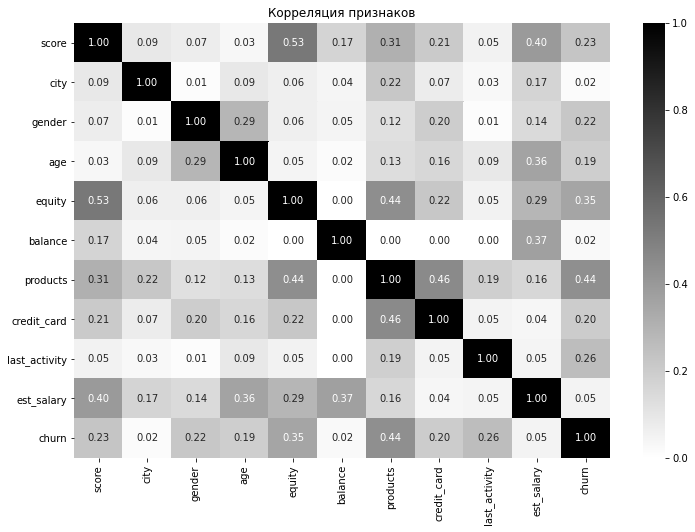

In [11]:
#создаем тепловую карту корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(corr_phik, annot=True, fmt='.2f', cmap='binary')
plt.title('Корреляция признаков')
plt.show();

**Вывод:** пропусков в столбце с возрастом меньше 1% от всех данных, поэтому их можно отнести к категории MAR и спокойно отбросить. А вот в столбце с балансом ситуация складывается иначе, поэтому была создана тепловая карта корреляции для анализа зависимости данных. По ней видно, что баланс имеет зависимость с доходом и баллами кредитного скоринга. Соответсвенно, эти пропуски можно отнести к типу MNAR и без дополнительных обоснований заменять или избавляться от них не стоит.

<a id="анализ"></a>
## Исследовательский анализ данных (EDA)

<a id="отточность"></a>
### Определение значимых признаков отточности

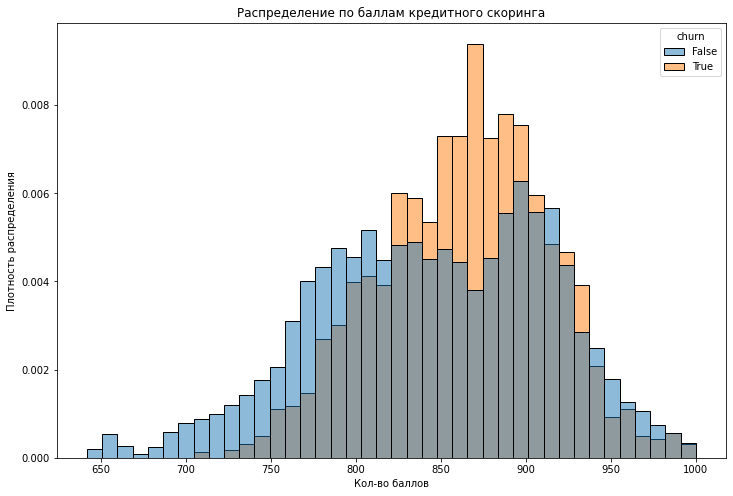

In [12]:
#отточность по баллам кредитного скоринга
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='score', hue='churn', stat='density', common_norm=False)
plt.xlabel('Кол-во баллов')
plt.ylabel('Плотность распределения')
plt.title('Распределение по баллам кредитного скоринга')
plt.show();

**Промежуточные выводы:** по графику можно заметить, что чаще всего уходят клиенты с баллами от 820 до 900.

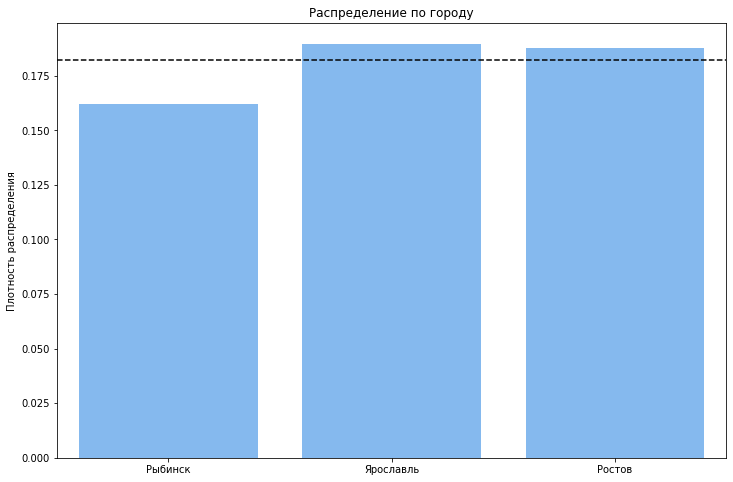

In [13]:
#отточность по городу
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='city', y='churn', color='#74b9ff', ci=None)
plt.axhline(df['churn'].mean(), color='black', linestyle='--')
plt.xlabel('')
plt.ylabel('Плотность распределения')
plt.title('Распределение по городу')
plt.show();

**Промежуточные выводы:** по графику можно заметить, что клиенты из ярославля и Ростова уходят чаще клиентов из Рыбинска.

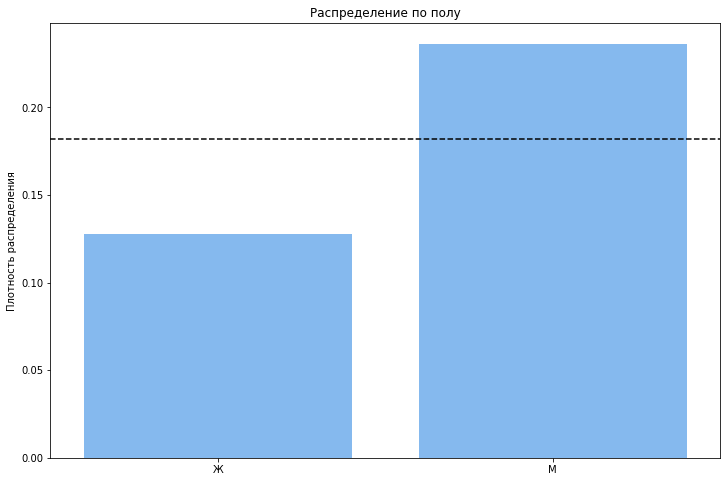

In [14]:
#отточность по полу
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='gender', y='churn', color='#74b9ff', ci=None)
plt.axhline(df['churn'].mean(), color='black', linestyle='--')
plt.xlabel('')
plt.ylabel('Плотность распределения')
plt.title('Распределение по полу')
plt.show();

**Промежуточные выводы:** по графику можно заметить, что мужчины уходят чаще женщин.

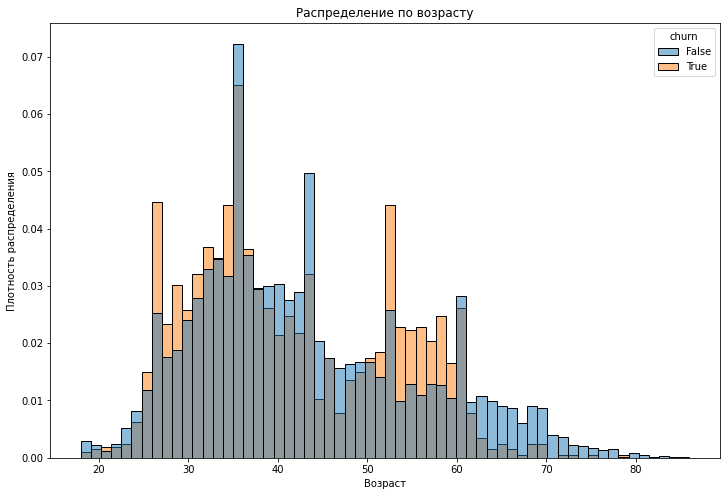

In [15]:
#отточность по возрасту
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='age', hue='churn', bins=60, stat='density', common_norm=False)
plt.xlabel('Возраст')
plt.ylabel('Плотность распределения')
plt.title('Распределение по возрасту')
plt.show();

**Промежуточные выводы:** по графику можно заметить, что уходу из банка больше подвержены люди в возрасте 25-35 и 50-60 лет.

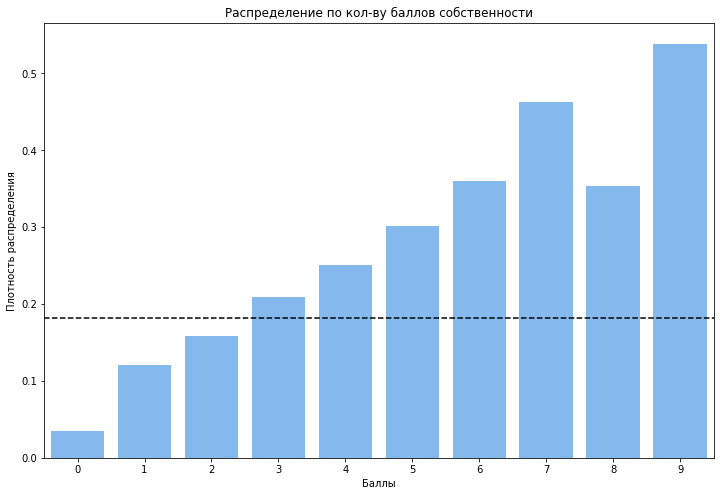

In [16]:
#отточность по кол-ву баллов собственности
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='equity', y='churn', color='#74b9ff', ci=None)
plt.axhline(df['churn'].mean(), color='black', linestyle='--')
plt.xlabel('Баллы')
plt.ylabel('Плотность распределения')
plt.title('Распределение по кол-ву баллов собственности')
plt.show();

**Промежуточные выводы:** по графику можно заметить, что отточность увеличивается по мере роста количества собственности у клиентов, с небольшим провалом на 8-ом балле. 

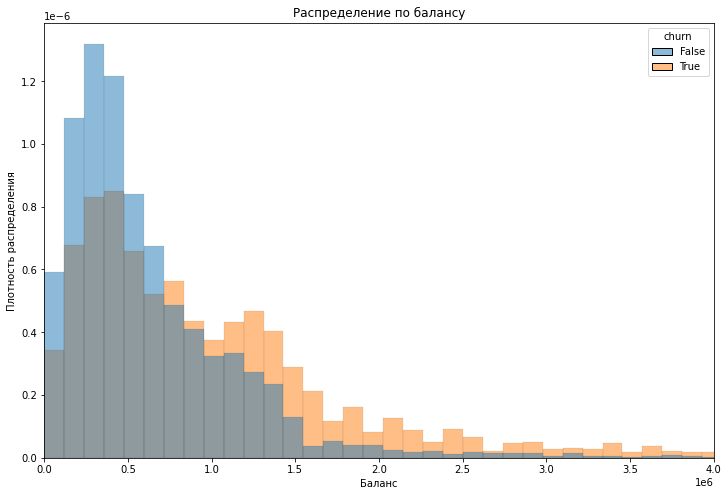

In [17]:
#отточность по балансу на счете
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='balance', hue='churn', bins=1000, stat='density', common_norm=False)
plt.xlim(0, 4000000)
plt.xlabel('Баланс')
plt.ylabel('Плотность распределения')
plt.title('Распределение по балансу')
plt.show();

**Промежуточные выводы:** по графику можно заметить, что клиенты начинают уходить из банка с балансом выше 700 тысяч рублей.

In [18]:
#проверим количетсво клиентов в каждой группе
df['products'].value_counts()

2    5126
1    3341
3    1039
4     474
5      19
0       1
Name: products, dtype: int64

In [19]:
#удалим клиента без продуктов банка
df = df[df['products'] != 0]

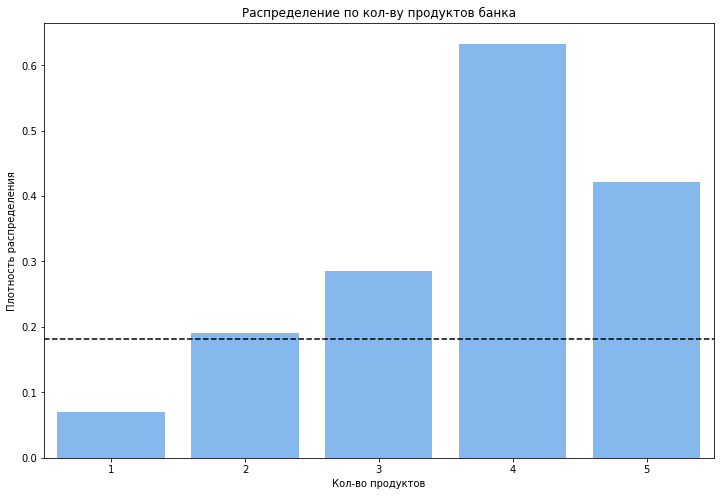

In [20]:
#отточность по кол-ву продуктов банка
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='products', y='churn', color='#74b9ff', ci=None)
plt.axhline(df['churn'].mean(), color='black', linestyle='--')
plt.xlabel('Кол-во продуктов')
plt.ylabel('Плотность распределения')
plt.title('Распределение по кол-ву продуктов банка')
plt.show();

**Промежуточные выводы:** по графику можно заметить, что самыми надежными оказываются клиенты с 1-2 продуктами. Клиент без продуктов банка всего 1, поэтому на графике возникает такая аномалия - его я решила удалить из датафрейма.

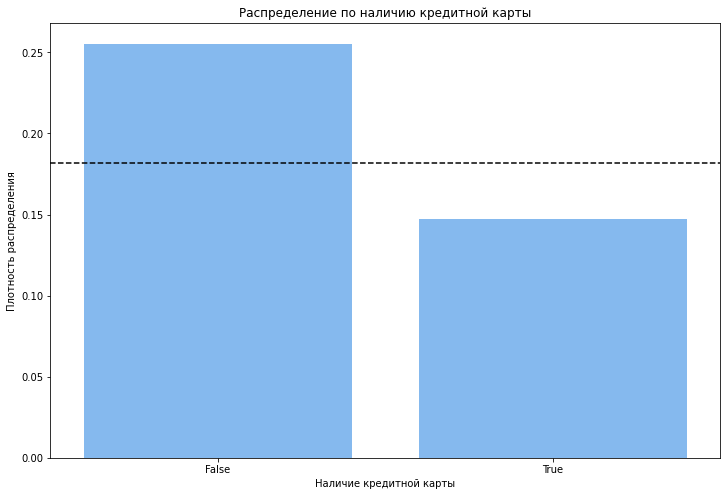

In [21]:
#отточность по наличию кредитной карты
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='credit_card', y='churn', color='#74b9ff', ci=None)
plt.axhline(df['churn'].mean(), color='black', linestyle='--')
plt.xlabel('Наличие кредитной карты')
plt.ylabel('Плотность распределения')
plt.title('Распределение по наличию кредитной карты')
plt.show();

**Промежуточные выводы:** по графику можно заметить, что клиенты без кредитной карты более склонны к оттоку. 

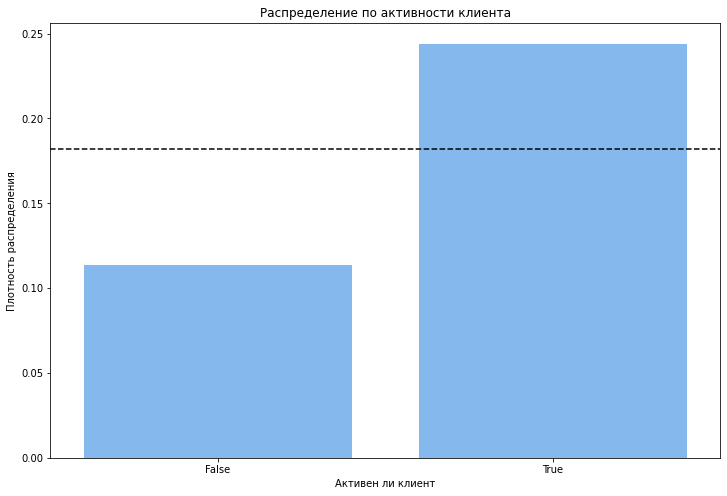

In [22]:
#отточность по активности клиента
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='last_activity', y='churn', color='#74b9ff', ci=None)
plt.axhline(df['churn'].mean(), color='black', linestyle='--')
plt.xlabel('Активен ли клиент')
plt.ylabel('Плотность распределения')
plt.title('Распределение по активности клиента')
plt.show();

**Промежуточные выводы:** по графику можно заметить, что активные клиенты чаще покидают банк.

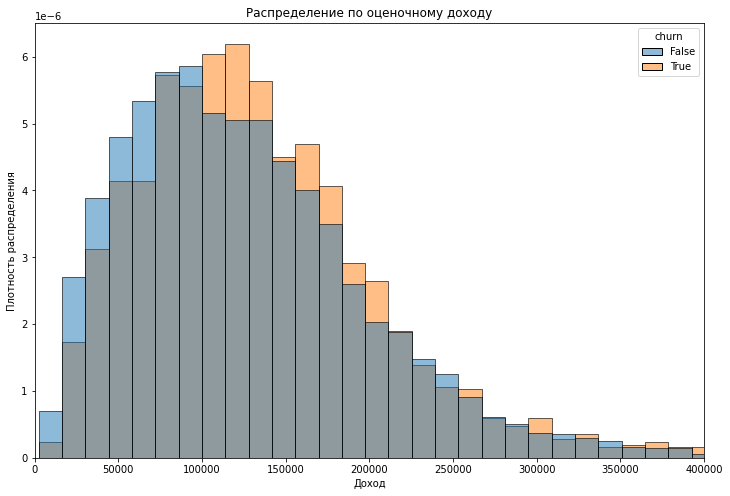

In [23]:
#отточность по оценочному доходу
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='est_salary', hue='churn', bins=100, stat='density', common_norm=False)
plt.xlim(0, 400000)
plt.xlabel('Доход')
plt.ylabel('Плотность распределения')
plt.title('Распределение по оценочному доходу')
plt.show();

**Промежуточные выводы:** по графику можно заметить, что наибольший шанс отточности у клиентов с доходом в интервале 100-200 тысяч рублей.

<a id="портреты"></a>
### Сравнение портретов типичных клиентов, которые склонны и не склонны уходить из банка

Из предыдущего пункта можно сформулировать типичные черты клиентов, склонных и не склонных уходить из банка:

| Характеристика            | Лояльный клиент   | Нелояльный клиент      |
|:--------------------------|:------------------|:-----------------------|
| баллы кредитного скоринга | 650-800, 920, 950 | 820-900                |
| город                     | Рыбинск           | Ярославль, Ростов      |
| пол                       | женский           | мужской                |
| возраст                   | 35-50, 60+        | 25-35, 50-60           |
| баллы собственности       | 0-2               | 3-9                    |
| баланс                    | до 600.000 рублей | >700.000 рублей        |
| кол-во продуктов банка    | 1-2               | 3-5                    |
| кредитная карта           | есть              | отсутствует            |
| активность                | неактивные        | активные               |
| доход                     | 0-100.000 рублей  | 100.000-200.000 рублей |

<a id="корреляция"></a>
### Корреляционный анализ

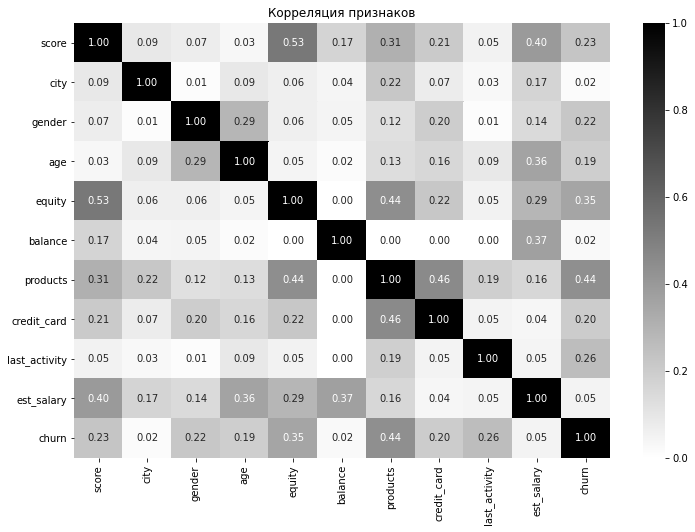

In [24]:
#дублируем тепловую карту корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(corr_phik, annot=True, fmt='.2f', cmap='binary')
plt.title('Корреляция признаков')
plt.show();

**Выводы:** для анализа карты я воспользовалась шкалой корреляции Чеддока. Итак, можно выделить следующие пункты:

 - баллы кредитного скоринга заметно коррелируют с количеством баллов собственности клиента; также наблюдается умеренная корреляция с количеством продуктов банка и с оценочным доходом.
 - город, пол и активность клиента со всеми признаками имеют слабую корреляцию.
 - умеренную корреляцию можно наблюдать между показателем возраста клиента и его оценочным доходом.
 - количество баллов собственности помимо баллов кредитного скоринга, умеренно коррелирует с показателем количества продуктов банка и с признаком оттока.
 - баланс на счете умеренно связан с оценочным уровнем дохода клиента.
 - количество продуктов банка, помимо вышесказанного, умеренно коррелирует с наличием кредитной карты и с признаком оттока.
 
Поскольку в данной работе нас интересует отток клиентов, стоит обратить особое внимание на то, что признак оттока сильнее всего коррелирует с количеством продуктов банка в пользовании у клиента и количеством баллов собственности.

<a id="гипотезы"></a>
## Формулировка и проверка статистических гипотез

1. Гипотеза различия дохода между теми клиентами, которые ушли и теми, которые остались.
2. Гипотеза различия количетсва продуктов банка у клиентов, которые ушли и тех, которые остались.
3. Гипотеза различия возраста клиентов, которые ушли и тех, которые остались.

Чтобы понять, можно ли применять t-тест, нужно проверить три условия:

1. Генеральные совокупности не зависят друг от друга.
2. Выборочные средние нормально распределены.
3. Дисперсии рассматриваемых генеральных совокупностей равны.

In [25]:
df_stay = df.query('churn == 0')
df_stay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8180 entries, 1 to 9999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        8180 non-null   int64  
 1   score          8180 non-null   int64  
 2   city           8180 non-null   object 
 3   gender         8180 non-null   object 
 4   age            8155 non-null   float64
 5   equity         8180 non-null   int64  
 6   balance        5898 non-null   float64
 7   products       8180 non-null   int64  
 8   credit_card    8180 non-null   bool   
 9   last_activity  8180 non-null   bool   
 10  est_salary     8180 non-null   float64
 11  churn          8180 non-null   bool   
 12  sign           8180 non-null   int64  
dtypes: bool(3), float64(3), int64(5), object(2)
memory usage: 726.9+ KB


In [26]:
df_away = df.query('churn == 1')
df_away.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1819 entries, 0 to 9994
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        1819 non-null   int64  
 1   score          1819 non-null   int64  
 2   city           1819 non-null   object 
 3   gender         1819 non-null   object 
 4   age            1818 non-null   float64
 5   equity         1819 non-null   int64  
 6   balance        1807 non-null   float64
 7   products       1819 non-null   int64  
 8   credit_card    1819 non-null   bool   
 9   last_activity  1819 non-null   bool   
 10  est_salary     1819 non-null   float64
 11  churn          1819 non-null   bool   
 12  sign           1819 non-null   int64  
dtypes: bool(3), float64(3), int64(5), object(2)
memory usage: 161.6+ KB


**Вывод:** для первых двух выдвинутых гипотез можно использовать t-тест Стьюдента, но так как сравниваемые данные заметно отличаются по количеству (8180 и 1819), а диспресии совокупностей проверить не можем, параметру equal_var стоит задать значение False. Для третьей гипотезы стоит использовать тест Манна-Уитни, так как большой разброс данных.

<a id="1"></a>
### Первая гипотеза

Гипотеза различия дохода между теми клиентами, которые ушли и теми, которые остались.

**Нулевая гипотеза:** статистически значимых различий между доходами ушедших и оставшихся клиентов нет.

**Альтернативная гипотеза:** доход между клиентами, которые ушли и теми, которые остались, отличается.

In [27]:
alpha = 0.05

results = st.ttest_ind(df_stay['est_salary'], df_away['est_salary'], equal_var=False, alternative='two-sided')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 0.8724727072323815
Не получилось отвергнуть нулевую гипотезу


**Вывод:** вероятность случайно получить такое или большее различие между данными равна почти 89%. Это слишком большой процент, чтобы делать вывод о значимом различии между средними доходами, поэтому отвергнуть нулевую гипотезу нельзя.

<a id="2"></a>
### Вторая гипотеза

Гипотеза различия количетсва продуктов банка у клиентов, которые ушли и тех, которые остались.

**Нулевая гипотеза:** статистически значимых различий между количеством продуктов банка у ушедших и оставшихся клиентов нет.

**Альтернативная гипотеза:** количество продуктов банка у клиентов, которые ушли и тех, которые остались, отличается.

In [28]:
alpha = 0.05

results = st.ttest_ind(df_stay['products'], df_away['products'], equal_var=False, alternative='two-sided')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 3.241238337429691e-139
Отвергаем нулевую гипотезу


**Вывод:** полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что количество продуктов банка у клиентов, которые ушли и тех, которые остались, отличается.

<a id="3"></a>
### Третья гипотеза

Гипотеза различия возраста клиентов, которые ушли и тех, которые остались.

**Нулевая гипотеза:** статистически значимых различий между возрастом ушедших и оставшихся клиентов нет.

**Альтернативная гипотеза:** возраст клиентов, которые ушли и тех, которые остались, отличается.

In [29]:
alpha = 0.05

results = st.mannwhitneyu(df_stay['age'], df_away['age'], alternative='two-sided', nan_policy='omit')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 3.811912767980522e-06
Отвергаем нулевую гипотезу


**Вывод:** полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что возраст клиентов, которые ушли и тех, которые остались, отличается.

<a id="итоги"></a>
## Подведение промежуточных итогов

На данном этапе хотелось бы отметить некоторые признаки и выводы, полученные на этапе EDA, корреляции и гипотез.

1. Признаки оттока, полученные на этапе исследовательского анализа:
 - 820-900 баллов кредитного скоринга;
 - города Ярославль и Ростов;
 - мужской пол;
 - возраст 25-35, 50-60;
 - 3-9 баллов собственности;
 - баланс на счете более 700 тыс.руб.;
 - 3-5 продуктов банка;
 - отсутствует кредитная карта;
 - активный клиент;
 - доход 100-200 тыс.руб.

2. Признаки оттока по результатам корреляции:
 - количество продуктов банка и баллов собственности - умеренная зависмость;
 - активность, баллы скоринга, пол, наличие кредитки, возраст - слабая зависмость.
 
3. Признаки оттока по результатам проверки гипотез:
 - количество продуктов и возраст ушедших и оставшихся клиентов имеют статистическии значимые различия.
 
В итоге, для будущей сегментации я рассмотрю все признаки в нескольких комбинациях, чтобы определить наиболее отточных клиентов.

<a id="cегментация"></a>
## Сегментация

<a id="сегменты"></a>
### Выделение сегментов

Стоит отметить, что у выделенных признаков будут определены интервалы, включающие наибольший процент оттока клиентов.

Я выделила 5 сегментов:

**1 сегмент:**
- products - количетсво продуктов банка (больше или равно 3);
- credit_card - наличие кредитной карты (отсутсвует).

**2 сегмент:**
- equity - количество баллов собственности (больше или равно 3);
- score - баллы скоринга (820-900).

**3 сегмент:**
- last_activity - активность клиента (активные);
- age - возраст (25-35)
- gender - пол (мужской).

**4 сегмент:**
- est_salary - оценочный доход (100-200 тыс.руб.);
- city - город (Ярославль, Ростов).

**5 сегмент:**
- age - возраст (50-60);
- balance - баланс на счете (>700 тыс.руб.);
- credit_card - наличие кредитной карты (отсутствует).

In [30]:
print('средний отток клиентов по банку:', round(df['churn'].mean()*100, 1), '%')

средний отток клиентов по банку: 18.2 %


In [31]:
#создаем и изучаем первый сегмент
first_segment = df.loc[(df['products'] >= 3) & (df['credit_card'] == False), ['user_id', 'products', 'credit_card', 'churn']]
users_1 = first_segment['user_id'].count()
users_away_1 = first_segment.query('churn == 1')['user_id'].count()
part_1 = round(users_away_1/users_1*100, 2)

print('количество клиентов в сегменте:', users_1)
print('количество отточных клиентов в сегменте:', users_away_1)
print('уровень оттока в сегменте:', part_1, '%')

количество клиентов в сегменте: 820
количество отточных клиентов в сегменте: 265
уровень оттока в сегменте: 32.32 %


In [32]:
#создаем и изучаем второй сегмент
second_segment = df.query('equity >= 3 & score >= 820 & score <=900')[['user_id', 'equity', 'score', 'churn']]
users_2 = second_segment['user_id'].count()
users_away_2 = second_segment.query('churn == 1')['user_id'].count()
part_2 = round(users_away_2/users_2*100, 2)

print('количество клиентов в сегменте:', users_2)
print('количество отточных клиентов в сегменте:', users_away_2)
print('уровень оттока в сегменте:', part_2, '%')

количество клиентов в сегменте: 2850
количество отточных клиентов в сегменте: 865
уровень оттока в сегменте: 30.35 %


In [33]:
#создаем и изучаем третий сегмент
third_segment = (
    df.query('last_activity == True & age >= 25 & age <=35 & gender == "М"')
    [['user_id', 'last_activity', 'age', 'gender', 'churn']])
users_3 = third_segment['user_id'].count()
users_away_3 = third_segment.query('churn == 1')['user_id'].count()
part_3 = round(users_away_3/users_3*100, 2)

print('количество клиентов в сегменте:', users_3)
print('количество отточных клиентов в сегменте:', users_away_3)
print('уровень оттока в сегменте:', part_3, '%')

количество клиентов в сегменте: 973
количество отточных клиентов в сегменте: 335
уровень оттока в сегменте: 34.43 %


In [34]:
#создаем и изучаем четвертый сегмент
fourth_segment = (
    df.query('est_salary >= 100000 & est_salary <= 200000 & city == "Ярославль" | city == "Ростов"')
    [['user_id', 'est_salary', 'city', 'churn']])
users_4 = fourth_segment['user_id'].count()
users_away_4 = fourth_segment.query('churn == 1')['user_id'].count()
part_4 = round(users_away_4/users_4*100, 2)

print('количество клиентов в сегменте:', users_4)
print('количество отточных клиентов в сегменте:', users_away_4)
print('уровень оттока в сегменте:',part_4, '%')

количество клиентов в сегменте: 3991
количество отточных клиентов в сегменте: 802
уровень оттока в сегменте: 20.1 %


In [35]:
#создаем и изучаем пятый сегмент
fifth_segment = (
    df.query('age >= 50 & age <= 60 & balance > 700.000 & credit_card == False')
    [['user_id', 'age', 'credit_card', 'balance', 'churn']])
users_5 = fifth_segment['user_id'].count()
users_away_5 = fifth_segment.query('churn == 1')['user_id'].count()
part_5 = round(users_away_5/users_5*100, 2)

print('количество клиентов в сегменте:', users_5)
print('количество отточных клиентов в сегменте:', users_away_5)
print('уровень оттока в сегменте:', part_5, '%')

количество клиентов в сегменте: 601
количество отточных клиентов в сегменте: 249
уровень оттока в сегменте: 41.43 %


**Вывод:** каждый сегмент состоит из 2-3 признаков, определенных на наиболее отточном интервале. Критерии были скомбинированы и подобраны так, чтобы в каждом сегменте находилось не менее 500 клиентов и уровень оттока был выше, чем средний по банку.

<a id="отбор"></a>
### Отбор лучших

In [36]:
#создаем датафрейм с сегментами и отсортировываем их
top = pd.DataFrame({
    'users': [users_1, users_2, users_3, users_4, users_5],
    'users_away': [users_away_1, users_away_2, users_away_3, users_away_4, users_away_5],
    'part': [part_1, part_2, part_3, part_4, part_5]})
top.sort_values(by='users_away', ascending=False)

,users,users_away,part
1,2850,865,30.35
3,3991,802,20.10
2,973,335,34.43
0,820,265,32.32
4,601,249,41.43


**Вывод:** на данном этапе сфомированные сегменты были приоритизированы по количеству отточных клиентов. Это позовлит отделу маркетинга понимать, на что стоит обратить внимание в первую очередь в случае, если ресурсов не хватит на охват всех выделенных сегментов.

<a id="рекомендации"></a>
## Рекомендации

В ходе данной работы были выявлены признаки оттока клиентов, а также сформированы сегменты с процентом оттока выше, чем средний по банку. Проанализировав их и составив приоритет, также хотелось бы дать некоторые рекомендации отделу маркетинга:

- В первую очередь стоить обратить внимание на клиентов с высоким уровнем доверия по кредиту (баллы скоринга) и с растущими показателями количества собственности. Можно сказать, что с повышением уровня жизни, клиенты решают уйти из банка, что стоит предотвратить. Можно предоставить им персональные предложения - например, выгодные условия по вкладу или ипотеке, так как они уже "завоевали" доверие банка и такое предложение им может быть акутально для сбережения средств или при покупке новой собственности.
- В четвертом сегменте были затронуты клиенты из Ярославля и Ростова с доходом 100-200 тысяч рублей. Именно этот интервал был замечен, как самый убыточный по клиентам для банка. На мой взгляд, для таких клиентов можно разработать персонализированнные предложения по кэшбекам в местах их города, а также предложить льготы при выборе карты нашего банка, как основной для зарплаты.
- В следующий немаловажный сегмент вошли активные юноши в возрасте 25-35 лет. Было выявлено, что чем чаще человек совершает покупки, тем чаще он уходит из банка - это может быть связано, например, с большими комиссиями при переводах или малой популярность банка. Можно устроить акции типа "бонус за друга" или "бесплатные переводы между клиентами банка". Также было замечено, что мужчины уходят из банка чаще женщин - стоит проработать стратегию персонализированных предложений для мужского пола - например, добавить в категории кэшбека магазины для рыбалки, мужские салоны, интрументы. 
- Отсутствие кредитной карты также сказывается на отток - клиентам можно предложить повышенный кредитный лимит, льготный период и разные кэшбеки, чтобы возникло желание воспользоваться продуктом именно этого банка.
- Также была замечена закономерность, что наиболее "надежные" клиенты имеют 1-2 продуктов от банка, вероятно, это связано с "навязанными" менеджерами продуктами из-за которых клиенты решают уйти - можно порекомендовать исключить "агрессивный маркетинг".

Также для всех клиентов можно провести опрос удовлетворенности разными продуктами и стратегиями банка.

<a id="вывод"></a>
## Общий вывод

В процессе работы были выполнены следующие этапы, а также сделаны выводы по ним:

1. Загрузка данных и изучение данных
 - в данных содержится 12 столбцов и 10000 строк 
 - названия изменены на наиболее читаемые
 - обнаружены пропуски в данных о возрасте и о балансе клиентов
 
2. Подготовка данных
 - для 5 столбцов из датафрейма изменен тип на наиболее подходящий
 - не обнаружено явных дубликатов, однако замечено 146 повторяющихся строк по столбцу user_id
 - определена природа неявных дубликатов и принято решение оставить их без изменений
 - пропуски в столбце с возрастом оставлены без изменений, так как они составляют менее 1% от всех данных
 - пропуски в столбце с балансом оставлены без изменений, так как они относятся к типу MNAR
 
3. Исследовательский анализ (EDA)
 - определены основные признаки оттока и их интервалы
 - проведено сравнение лояльных и нелояльных клиентов на основе выделенных признаков
 - интерпретация тепловой карты корреляции проведена на основе шкалы Чеддока
 - изучены зависимости параметров и выделены 2 из них, наиболее коррелирующие с признаком оттока 

4. Формулировка и проверка статистических гипотез
 - выдвинут и обоснован метод проверки гипотез (t-тест Стьюдента со значением False для параметра equal_var и тест Манна-Уитни)
 - проверка первой гипотезы показала, что статистичеси значимых различий в среднем доходе клиентов нет
 - проверка второй гипотезы показала, что количество продуктов банка у клиентов, которые ушли и тех, которые остались, отличается
 - проверка третьей гипотезы показала, что возраст клиентов, которые ушли и тех, которые остались, отличается
 
5. Подведение промежуточных итогов
 - обобщены выводы, полученные на этапе EDA, корреляции и гипотез
 - выдвинуты предложения о признаках, которые будут рассмотрены при сегментации
 
6. Сегментация
 - выделены 5 сегментов из 2-3 признаков, определенных на наиболее отточном интервале
 - сегменты отсортированы по количеству отточных клиентов, что позволит определить приоритет действий

7. Рекомендации
 - на основе всех пунктов выдвинуты предложения по удержанию клиентов для отдела маркетинга